In [322]:
# Import program libraries
import numpy as np
import scipy.stats as sts
import scipy.special as spc
import scipy.optimize as opt
import scipy.integrate as intg
import matplotlib.pyplot as ply
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

# Problem 1 Import the dataset
data1 = np.loadtxt('usincmoms.txt', delimiter = '\t')

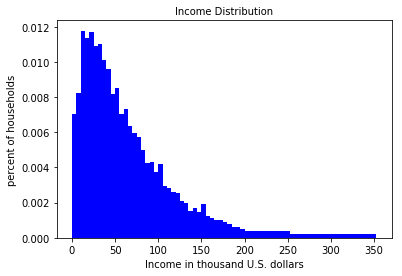

In [323]:
# (a)
# Create scales of 2500 for the larger part of the data.
midpt_large_init = 202500
midpt_large = []
while midpt_large_init < 350000:
    midpt_large.append(midpt_large_init)
    midpt_large_init += 5000

midpt_large = np.array(midpt_large)

# Adjust the height of the last two bars.
height = np.append(np.repeat(data1[40,0]/10,10),np.repeat(data1[41,0]/20,20))

# Plot all.
plt.bar(data1[0:40,1]/1000, data1[0:40,0]/5, width =5, align = 'center', color = 'b')
plt.bar(midpt_large/1000, height/5, width = 10, align = 'center', color = 'b')
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.show()

In [324]:
# (b)
# Define the model moments. We calculate the probability of each bin under the log normal distribution assumption.
upper = np.append(data1[0:40,1]/1000+2.5, [data1[40,1]/1000+25, data1[41,1]/1000+50])
lower = np.append(data1[0:40,1]/1000-2.5, [data1[40,1]/1000-25, data1[41,1]/1000-50])

def model_moments(mu,sigma):
    prob = sts.lognorm.cdf(upper, sigma, scale = np.exp(mu)) - sts.lognorm.cdf(lower, sigma, scale = np.exp(mu))
    return prob

# Define the error vector.
def err_vec(xvals, mu, sigma):
    moms_model = model_moments(mu,sigma)
    moms_data = xvals[:,0]
    err_vec = moms_model - moms_data
    return err_vec

# Define the criteria function.
def crit(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(np.transpose(err), W), err)
    return crit_val

In [325]:
# Set initial values.
mu_init = np.log(data1.mean())
sigma_init = np.log(data1.std())
params_init = np.array([mu_init, sigma_init])

# Define a weighted matrix.
W = np.diag(data1[:,0])

# Conduct GMM estimation.
gmm_args = (data1, W)

result = opt.minimize(crit, params_init, args = gmm_args, method = 'L-BFGS-B', bounds = ((None,None),(1e-10,None)))
mu_gmm, sigma_gmm = result.x
print(result)

      fun: 3.5230053585546136e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.98225022e-06,  -2.56798028e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 105
      nit: 16
   status: 0
  success: True
        x: array([ 3.95372273,  1.02271787])


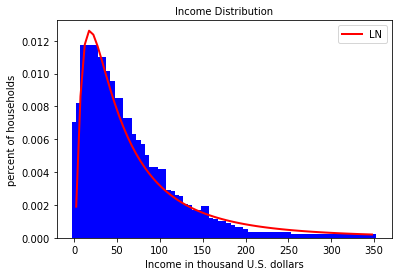

In [326]:
# Plot the result.
pts = np.append(data1[0:40,1]/1000, midpt_large/1000)
plt.bar(data1[0:40,1]/1000, data1[0:40,0]/5, width = 10, align = 'center', color = 'b')
plt.bar(midpt_large/1000, height/5, width = 10, align = 'center', color = 'b')
plt.plot(pts, sts.lognorm.pdf(pts, sigma_gmm, scale = np.exp(mu_gmm)), color = 'r', linewidth = 2, label = 'LN')
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

In [327]:
# (c)
# Repeat the same exercise with the gamma distribution.
# Define the model moments.
def model_moments(alpha,beta):
    prob = sts.gamma.cdf(upper, alpha, scale = beta) - sts.gamma.cdf(lower, alpha, scale = beta) 
    return prob

# Define the error vector.
def err_vec(xvals, alpha, beta):
    moms_model = model_moments(alpha,beta)
    moms_data = xvals[:,0]
    err_vec = moms_model - moms_data
    return err_vec

# Define the criteria function.
def crit(params, *args):
    alpha, beta = params
    xvals, W = args
    err = err_vec(xvals, alpha, beta)
    crit_val = np.dot(np.dot(np.transpose(err), W), err)
    return crit_val

In [328]:
# Set the initial values.
alpha_init = 3
beta_init = 20
params_init = np.array([alpha_init, beta_init])

# Conduct GMM estimation.
result = opt.minimize(crit, params_init, args = gmm_args, method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_gmm, beta_gmm = result.x
print(result)

      fun: 1.4961242533922526e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.75060791e-07,  -1.62834308e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 14
   status: 0
  success: True
        x: array([  1.50440144,  41.15084734])


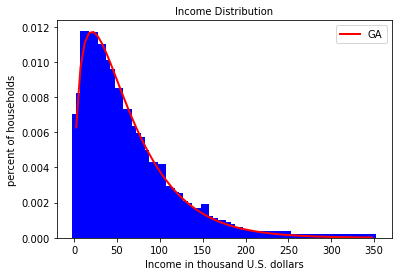

In [329]:
# Plot the result.
plt.bar(data1[0:40,1]/1000, data1[0:40,0]/5, width = 10, align = 'center', color = 'b')
plt.bar(midpt_large/1000, height/5, width = 10, align = 'center', color = 'b')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'r', linewidth = 2, label = 'GA')
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

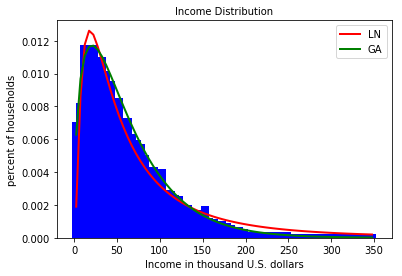

In [330]:
# (d)
# Plot the both estimation results.
plt.bar(data1[0:40,1]/1000, data1[0:40,0]/5, width = 10, align = 'center', color = 'b')
plt.bar(midpt_large/1000, height/5, width = 10, align = 'center', color = 'b')
plt.plot(pts, sts.lognorm.pdf(pts, sigma_gmm, scale = np.exp(mu_gmm)), color = 'r', label = 'LN', linewidth = 2)
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'g', label = 'GA', linewidth = 2)
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

In [331]:
# We can compare these two results by the values of minimized functions. Since the estimation with the gamma
# distribution records the lower value, we can conclude that the estmation in (c) provides the better result.

In [332]:
# (e)
# First, estimate the paremeters using the identity matrix.
result_1 = opt.minimize(crit, params_init, args = (data1, np.identity(data1.shape[0])), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_1, beta_1 = result_1.x
print(result_1)

# Compute the two-step estimator.
err_vec_1 = np.reshape(err_vec(data1, alpha_1, beta_1),(42,1))
omega = (err_vec_1 @ err_vec_1.T) / data1.shape[0] 
W_2_step = np.linalg.pinv(omega)

# Estimate the parameters using the two-step estimator.
params_init = np.array([alpha_1, beta_1])
result = opt.minimize(crit, params_init, args = (data1, W_2_step), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_2_step, beta_2_step = result.x
print(result)

      fun: 0.00035229456278478797
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.41759434e-08,  -2.71050543e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 63
      nit: 16
   status: 0
  success: True
        x: array([  1.3765432 ,  48.06669837])
      fun: 41.999999986664776
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.10507176e-04,  -9.52127266e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([  1.37653037,  48.06670088])


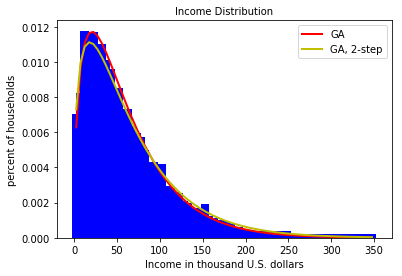

In [333]:
# To see the goodness of fit, we plot this result.
plt.bar(data1[0:40,1]/1000, data1[0:40,0]/5, width = 10, align = 'center', color = 'b')
plt.bar(midpt_large/1000, height/5, width = 10, align = 'center', color = 'b')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'r', label = 'GA', linewidth = 2)
plt.plot(pts, sts.gamma.pdf(pts, alpha_2_step, scale = beta_2_step), color = 'y', label = 'GA, 2-step', linewidth = 2)
plt.title('Income Distribution', fontsize=10)
plt.xlabel('Income in thousand U.S. dollars')
plt.ylabel('percent of households')
plt.legend(loc = 'upper right')
plt.show()

In [334]:
# Since we used the different weighted matrix, we cannot directly compare these two results, despite the fact that
# the estimation with the two-step estimator provides the lower value of the criterion function. Also, we cannot
# determine which estimation fits with the data better from the graph either.

In [335]:
# Problem 2
# Import the data.
data2 = np.loadtxt('MacroSeries.txt', delimiter = ',')

In [336]:
# Back out z_t and define the data moments.
def data_moments(data, alpha, beta, rho, mu):
    z = np.zeros(len(data2))
    for i in range(0, len(data2)):
        z[i] = np.log(data2[i][3]/(alpha*(data2[i][1]**(alpha-1))))
    moments = np.zeros(4)
    for i in range(0, len(data2)-1):
        moments[0] += z[i+1] - rho*z[i] - (1-rho)*mu
        moments[1] += (z[i+1] - rho*z[i] - (1-rho)*mu)*z[i]
        moments[2] += (beta*alpha*np.exp(z[i+1])*(data2[i+1][1]**(alpha-1))*data2[i][0]/data2[i+1][0]) - 1
        moments[3] += ((beta*alpha*np.exp(z[i+1])*(data2[i+1][1]**(alpha-1))*data2[i][0]/data2[i+1][0]) - 1)/data2[i][2]
    return moments

# Define model moments (they are all zero by assumption).
def model_moments(data, alpha, beta, rho, mu):
    return np.zeros(4)

# Define the error vector.
def err_vec(data, alpha, beta, rho, mu):
    datamoments = data_moments(data, alpha, beta, rho, mu)
    err_vec = (datamoments - model_moments(data, alpha, beta, rho, mu))
    return err_vec

# Define the criterion function.
def crit(params, *args):
    alpha, beta, rho, mu = params
    data2, W = args
    err = err_vec(data, alpha, beta, rho, mu)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [337]:
# Set the initial value.
alpha_init = 0.3
beta_init = 0.9
rho_init = 0.9
mu_init = 10
params_init = np.array([alpha_init, beta_init, rho_init, mu_init])

# Conduct GMM estimation.
W = np.eye(4)
gmm_args = (data2, W)
result = opt.minimize(crit, params_init, args=(gmm_args), method = 'L-BFGS-B', bounds = ((1e-10, 1-1e-10),(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None)))
alpha_gmm, beta_gmm, rho_gmm, mu_gmm, = result.x
print(result)

      fun: 0.00028601178190232741
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02984589, -0.00137348,  0.00675171, -0.00139675])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 95
      nit: 17
   status: 0
  success: True
        x: array([  0.29978188,   0.98999993,   0.89780612,  12.29756206])
